# Import

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [3]:
train_df = pd.read_csv("data/mitbih_train.csv", header=None)
test_df = pd.read_csv("data/mitbih_test.csv", header=None)
train_df.to_numpy()
test_df.to_numpy()

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        4.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        4.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        4.        ]])

In [8]:
train_df = pd.read_csv("data/mitbih_train.csv", header=None)
test_df = pd.read_csv("data/mitbih_test.csv", header=None)
train_df.to_numpy()
test_df.to_numpy()

x = np.copy(train_df.loc[:,train_df.columns!=187].to_numpy())
y = np.copy(train_df.loc[:,train_df.columns==187].to_numpy())
y = y > 0
y = y.astype(int)

test_x = np.copy(test_df.loc[:,test_df.columns!=187].to_numpy())
test_y = np.copy(test_df.loc[:,test_df.columns==187].to_numpy())
test_y = test_y > 0
test_y = test_y.astype(int)

train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.33)

In [9]:
model = XGBClassifier(tree_method="gpu_hist",
                          predictor="gpu_predictor",
                          objective="binary:logistic",
                          **params,
                          verbosity=1)
model.fit(train_x,train_y, eval_metric="auc", eval_set=[(train_x, train_y), (val_x, val_y)], verbose=False, early_stopping_rounds=10)
results = model.evals_result()
pred=model.predict(test_x)
f1_macro_score = f1_score(test_y, pred, average='macro')
confusion_matrix = metrics.confusion_matrix(test_y, pred)
print(confusion_matrix)
print(f1_macro_score)

C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[[18056    62]
 [  418  3356]]
0.960070777762592


# Initialize Model

In [5]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="multi:softprob",
                        verbosity=1)

# Print default setting
xgboost.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': 'gpu_predictor',
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': 1}

In [12]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [18]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [i/1000 for i in range(1, 300)]),
    'n_estimators': hp.choice('n_estimators', range(100,400,50)),
    'max_depth': hp.choice('max_depth', range(4,8,1)),
    'gamma': hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'min_child_weight': hp.choice('min_child_weight', range(0, 10, 1)),
    'colsample_bytree': hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'reg_alpha': hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'reg_lambda': hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

train_y = train_y > 0
train_y = train_y.astype(int)
# Objective function
def objective(params):
    global train_x, train_y
    xgboost = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="binary:logistic",
                        verbosity=1)
    scores = cross_val_score(xgboost, train_x, train_y, cv=kfold, scoring='f1', n_jobs=-1, error_score="raise")
    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    # loss = - best_score

    # Dictionary with information for evaluation
    return {'score': best_score, 'params': params, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

100%|██████████| 48/48 [04:12<00:00,  5.25s/trial, best loss: -0.9354431831212017]


In [4]:
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.05, 0.1]),
    'n_estimators': hp.choice('n_estimators', range(100,400,50)),
    'max_depth': hp.choice('max_depth', range(4,8,1)),
    'gamma': hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'min_child_weight': hp.choice('min_child_weight', range(0, 10, 1)),
    'colsample_bytree': hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),
    'reg_alpha': hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]),
    'reg_lambda': hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def objective(params):
    global train_x, train_y
    xgboost = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="multi:softprob",
                        verbosity=1)

    scores = cross_val_score(xgboost, train_x, train_y, cv=kfold, scoring='recall_macro', n_jobs=-1, error_score="raise")
    print(scores)
    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Trials to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

[0.8548117  0.83991029 0.84228045]                    
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                              
[0.8548117  0.83991029 0.84228045]                                               
[0.8548117  0.83991029 0.84228045]                                               
 25%|██▌       | 12/48 [05:25<16:17, 27.15s/trial, b

KeyboardInterrupt: 

In [19]:
print(best)
print(space_eval(space, best))

{'colsample_bytree': 4, 'gamma': 3, 'learning_rate': 90, 'max_depth': 0, 'min_child_weight': 4, 'n_estimators': 5, 'reg_alpha': 0, 'reg_lambda': 0}
{'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.091, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 350, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05}


In [10]:
params = {
    'learning_rate': 0.1067,
    'n_estimators': 184,
    'max_depth': 10,
    'gamma': 0.2952,
    'min_child_weight': 8.607,
    'colsample_bytree': 0.9875,
    'reg_alpha': 0.00003391,
    'reg_lambda': 0.0005003
}
model = XGBClassifier(tree_method="gpu_hist",
                        predictor="gpu_predictor",
                        objective="binary:logistic",
                        **params,
                        verbosity=1)
# Print default setting
model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.9875,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0.2952,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1067,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': 8.607,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 184,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': 'gpu_predictor',
 'random_state': None,
 'reg_alpha': 3.391e-05,
 'reg_lambda': 0.0005003,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': 1}


1 of kfold 3


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('auc', [0.9598042996412887, 0.9644107592453124, 0.9693451817874563, 0.970080429846796, 0.9754392537035047, 0.9772547332347092, 0.9778896699028383, 0.9788513416306354, 0.9803246002185233, 0.9813307966922087, 0.9822545596026095, 0.9832875398826346, 0.9840000716759895, 0.985719758161671, 0.9867078822818416, 0.9874191738459132, 0.987688966428321, 0.9887410699117349, 0.9894897762599613, 0.9899365006723896, 0.9904737360916005, 0.9918947671319767, 0.9921994950692086, 0.9924797323377301, 0.9928784778885233, 0.9931940230952718, 0.9937317381384214, 0.9945055063812935, 0.9946683160652591, 0.9951816814450193, 0.9956342447128202, 0.9958489083316586, 0.9961131101045504, 0.99644649402826, 0.9967076945492098, 0.9968444450089232, 0.9969453801171011, 0.9971383639105259, 0.9973683106535366, 0.9974647469715093, 0.9976198116551788, 0.9976906189695137, 0.9978515564733412, 0.9979344902452828, 0.9979784921393239, 0.9980256002673707, 0.9980512354464239, 0.9981561567853191, 0.9981

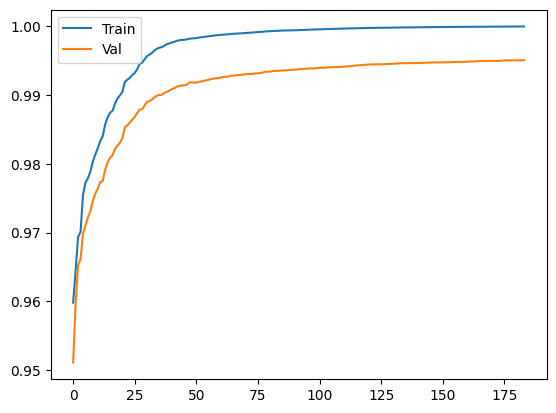

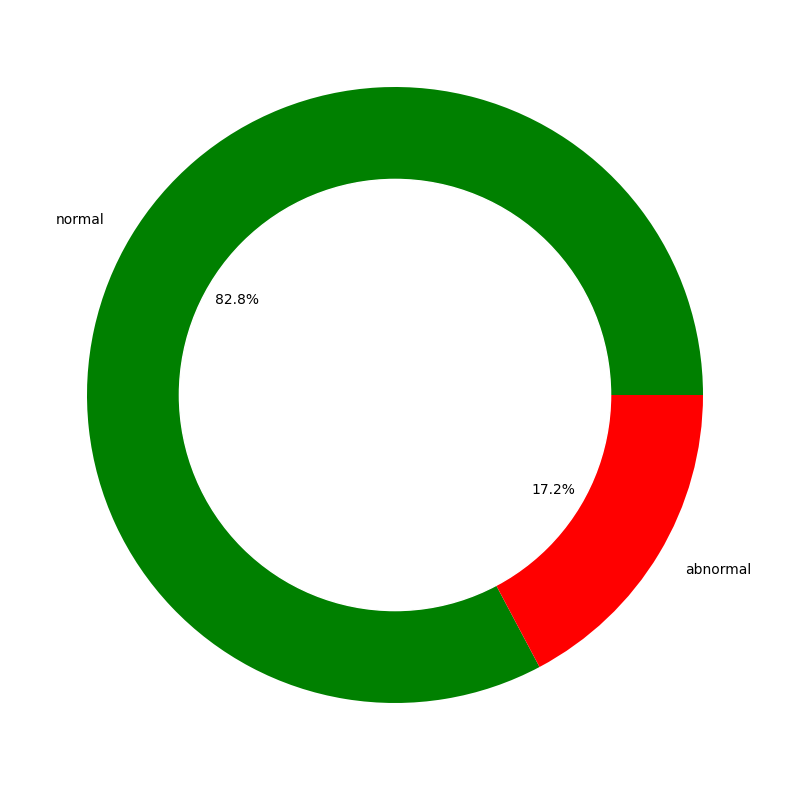

accuracy_score 0.9816828065046592
[[18068    50]
 [  351  3423]]
0.966845791404808

2 of kfold 3


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('auc', [0.9541519315248519, 0.9635397210033725, 0.967574498720423, 0.9716138019878128, 0.9744458629831328, 0.975986809271283, 0.9771632156351969, 0.9784065141000072, 0.9802372880769791, 0.9811706228814336, 0.9820705785357748, 0.9830620610527515, 0.9836443605374727, 0.9842793435212183, 0.984747492508552, 0.986092420815786, 0.9875535436829441, 0.9885375436547842, 0.989255617883567, 0.9900802190592796, 0.9905314010924763, 0.9913780834956113, 0.9920148522036775, 0.9929048705852135, 0.9932055052511926, 0.9937132314473484, 0.9941123300260621, 0.9943728100818681, 0.9948326387260266, 0.9951812337273942, 0.9954716285252077, 0.9957041627673207, 0.9959599165717832, 0.996181190972934, 0.9964162303752757, 0.9966366608029724, 0.9968442062261897, 0.9970693711391173, 0.9972332080005307, 0.9973398244909857, 0.9974041321804875, 0.9975329770791014, 0.9976595875065334, 0.997731630933208, 0.9978269453840282, 0.9979040042773398, 0.9979722467357628, 0.9980378358239848, 0.998084

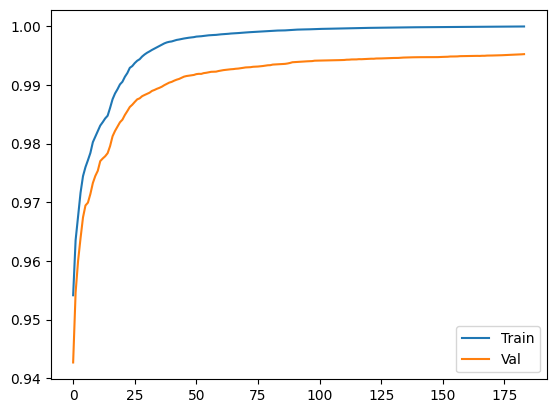

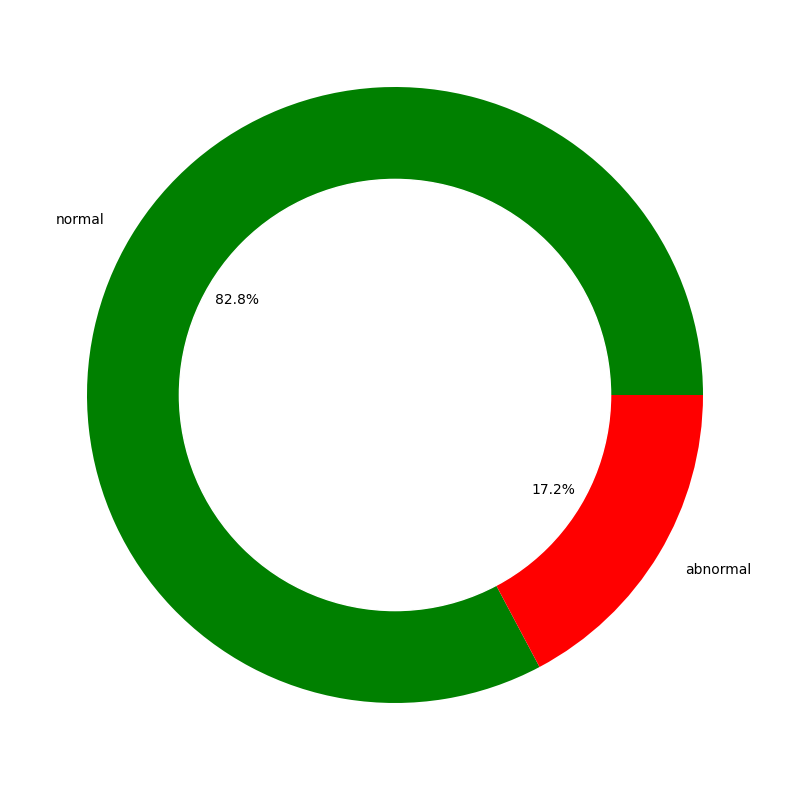

accuracy_score 0.9806321944089165
[[18062    56]
 [  368  3406]]
0.9649014543252993

3 of kfold 3


C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\DELL\PycharmProjects\Final-Thesis\venv\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('auc', [0.9585733231651643, 0.963865153706944, 0.9680578459266185, 0.9709344841961145, 0.9731114783581114, 0.9742899834610825, 0.9759399912545053, 0.9770372987479907, 0.9784004684912398, 0.9806646776067023, 0.9814408388242137, 0.9822176298714697, 0.9829005598206693, 0.9841606062637384, 0.9857791729974847, 0.9867885554353418, 0.9875882035391722, 0.9885420930367045, 0.9890362665105545, 0.9901723888057404, 0.9909873576210173, 0.9915616470849717, 0.9921973665608125, 0.9926073661708943, 0.9931224012113281, 0.9935285570075285, 0.9940735583592337, 0.9946657238732873, 0.9948171804315504, 0.9951829293564187, 0.9955366333019917, 0.995835434000775, 0.9961316999435771, 0.9963052952231835, 0.9965969485893279, 0.9967764562412901, 0.996892449885888, 0.9970163925581754, 0.9971196496457195, 0.9973015500332303, 0.9974972758011114, 0.9976072274025238, 0.9976763460713065, 0.9977427375361304, 0.9978193596177669, 0.997886295494249, 0.9979988538909926, 0.9980477233276653, 0.998

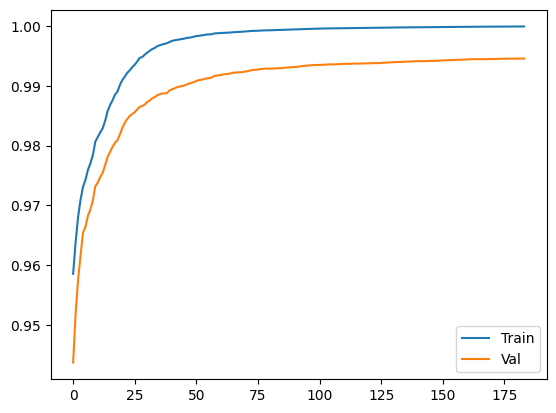

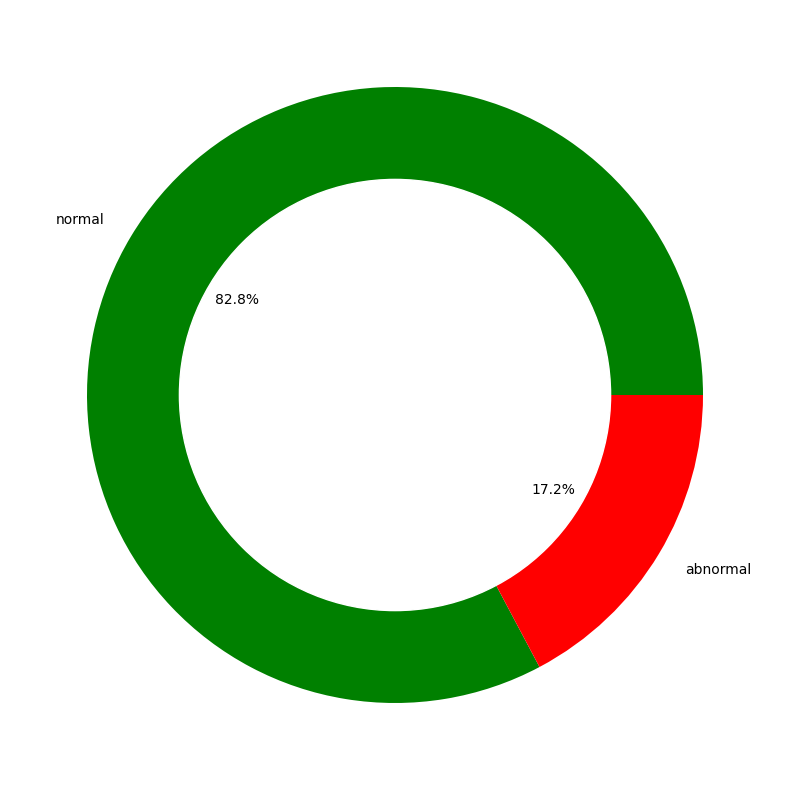

accuracy_score 0.9808605883427736
[[18061    57]
 [  362  3412]]
0.9653422352948435


In [11]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
i=1
train_error_list = []
val_error_list = []
best_score = 0
test_y = test_y > 0
test_y.astype(int)
for train_index, val_index in kf.split(x, y):
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = pd.DataFrame(x).loc[train_index].to_numpy(),pd.DataFrame(x).loc[val_index].to_numpy()
    ytr,yvl = pd.DataFrame(y).loc[train_index].to_numpy(),pd.DataFrame(y).loc[val_index].to_numpy()
    ytr = ytr > 0
    ytr.astype(int)
    yvl = yvl > 0
    yvl.astype(int)
    model.fit(xtr,ytr, eval_metric="auc", eval_set=[(xtr, ytr), (xvl, yvl)], verbose=False, early_stopping_rounds=10)
    pred=model.predict(test_x)
    results = model.evals_result()
    print(results)
    train_error_list.append(results["validation_0"]["auc"])
    val_error_list.append(results["validation_1"]["auc"])
    plt.plot(results["validation_0"]["auc"])
    plt.plot(results["validation_1"]["auc"])
    plt.legend(['Train', 'Val'])
    plt.show()

    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(pd.DataFrame(ytr).value_counts(), labels=['normal','abnormal'], colors=['green','red'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()
    # print("Train error: ", results["validation_0"]["merror"])
    # print("Validation error: ", results["validation_1"]["merror"])
    score = accuracy_score(test_y,pred)
    if best_score == 0 or best_score < score:
        best_score = score
        model.save_model('best.model')
    print('accuracy_score', accuracy_score(test_y,pred))
    confusion_matrix = metrics.confusion_matrix(test_y, pred)
    print(confusion_matrix)
    print(f1_score(test_y, pred, average='macro'))
    i += 1

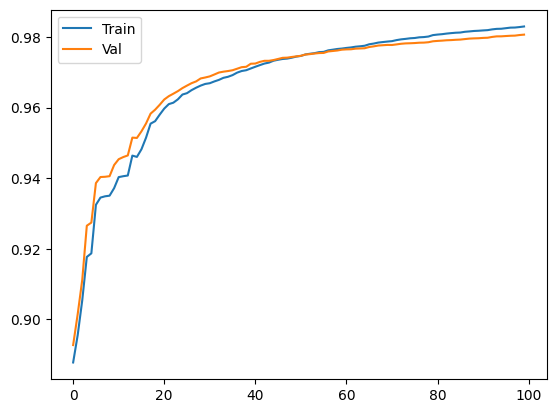

In [34]:
plt.plot(train_error_list[0])
plt.plot(val_error_list[0])
plt.legend(['Train', 'Val'])
plt.show()

In [28]:
print(results)

{'validation_0': OrderedDict([('auc', [0.8870663415990544, 0.9037974056934607, 0.9120457806377523, 0.9146702673478382, 0.9187544484749425, 0.9188035079111984, 0.9201653759736386, 0.922870179750576, 0.9257753588765866, 0.9368394380357793, 0.9400901435235287, 0.9408434285902736, 0.9411865701967369, 0.9458627839033367, 0.9453028678729248, 0.9475073778895746, 0.9525546472064311, 0.9549596969017269, 0.9558651901174566, 0.9578230702456405, 0.9600446959496318, 0.9614253676069481, 0.9628567363491819, 0.963878050854751, 0.9642706082272307, 0.9647737170490972, 0.96555103602172, 0.9662072949229051, 0.9669566236563657, 0.9674665744613999, 0.9676590252850694, 0.9680057776244788, 0.9684286094736507, 0.9690645395078786, 0.9695253021235899, 0.9698842639808325, 0.9704265521351664, 0.9706393312610866, 0.9710790574326774, 0.97159610038583, 0.9720492253470064, 0.9724053845662117, 0.9728511497084195, 0.9731021052481783, 0.9733938913220207, 0.9738382559922694, 0.9741132460026125, 0.9744956454357376, 0.97473

In [29]:
model.save_model('best.model')

In [9]:
print(pd.DataFrame(test_y).value_counts())

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
dtype: int64


In [25]:
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import f1_score

model = XGBClassifier()
model.load_model('best.model')
results = model.predict(test_x)
test_y = test_y > 0
test_y.astype(int)
confusion_matrix = metrics.confusion_matrix(test_y, results)
print(confusion_matrix)
print(f1_score(test_y, results, average='macro'))

[[18038    80]
 [  513  3261]]
0.9502416280785964


In [12]:
print(len(test_y))

21892


In [6]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (2).

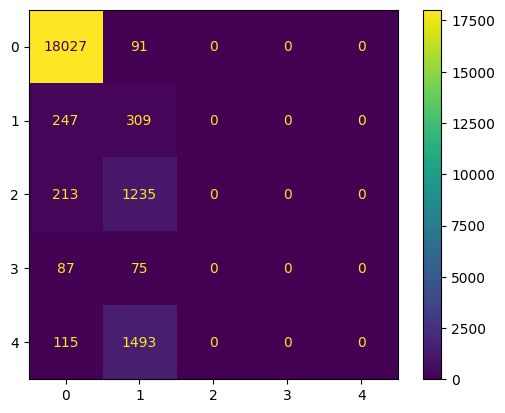

In [7]:
cm_display.plot()
plt.show()

In [38]:
import wandb
wandb.init(project="visualize", entity="betelegeuse")
wandb.log({'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.091, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 350, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'overall_f1': 0.9502416280785964})

colsample_bytree,▁
gamma,▁
learning_rate,▁
max_depth,▁
min_child_weight,▁
n_estimators,▁
overall_f1,▁
reg_alpha,▁
reg_lambda,▁
colsample_bytree,0.7
gamma,0.3


In [39]:
wandb.log({'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.091, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 350, 'reg_alpha': 1e-05, 'reg_lambda': 1e-05, 'overall_f1': 0.9502416280785964})

In [34]:
wandb.log({"": np.array(train_error_list[1]).T})